**Approach - <br>- Data Reading and Understanding<br>- Preprocessing => removal of punctuations, numbers, lemmatization, fixing contractions, spelling correction<br> - Pretrained embeddings => glove embeddings https://nlp.stanford.edu/data/glove.twitter.27B.zip and emoji embeddings https://github.com/MirunaPislar/emoji2vec/tree/master/models <br>- Tokenizer to convert comments to sequences<br>- Models => Dense Neural Network, Bidirectional LSTM, Bidirectional LSTM with dropout, Bidirectional LSTM with custom attention layer, Bidirectional LSTM with keras attention layer, CNN**

In [ ]:
#download glove embeddings
import urllib.request
import zipfile

urllib.request.urlretrieve("https://nlp.stanford.edu/data/glove.twitter.27B.zip", "glove.27B.zip")

with zipfile.ZipFile("glove.27B.zip","r") as zip_ref:
    zip_ref.extractall("./embeddings")

In [3]:
#All imports
from helpers import preprocessing

import math
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing
from sklearn.model_selection import train_test_split

#models
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from keras_self_attention import SeqSelfAttention

In [ ]:
#reload
import importlib
importlib.reload(preprocessing)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<module 'models' from '/content/models.py'>

In [4]:
#constants
EMBEDDING_DIM = 100
np.random.seed(42)
tf.random.set_seed(42)

### Step 1 - Data Reading and Understanding

In [6]:
#load training data
comments_df = pd.read_excel('./data/comments.xlsx', usecols=['comment','Sentiment' ])
comments_df.head()

,comment,Sentiment
0,hashtag hashtag hashtag hashtag hashtag hashta...,Neutral
1,send it pic _x000D_\n👁_x000D_\n👉 user,Neutral
2,if i get it on time maybe 😢,Mixed
3,gorgeous ❤,Positive
4,😍😍😍😍,Positive


In [7]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11856 entries, 0 to 11855
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    11856 non-null  object
 1   Sentiment  11856 non-null  object
dtypes: object(2)
memory usage: 185.4+ KB


In [8]:
comments_df['Sentiment'].value_counts(normalize=True)

Positive    0.813850
Neutral     0.127783
Negative    0.052800
Mixed       0.005567
Name: Sentiment, dtype: float64

### Step 2 - Data Preparation

In [9]:
#clean up and preprocessing using module - preprocessing
def prepare_data(df, is_train):
  processed_df = preprocessing.preprocess_data(df, 'comment')  
  processed_df = preprocessing.convert_emoticon(processed_df, 'spelling_corrected', False)
  processed_df['cleaned_comment'] = processed_df['emoticon_converted']

  if is_train:
    processed_df['target'] = processed_df['Sentiment'].map({"Neutral":0, "Positive":1, "Negative":2, "Mixed":3})

  return processed_df

In [10]:
train_processed_df = prepare_data(comments_df, True)
train_processed_df[['comment', 'cleaned_comment', 'target']].head()

,comment,cleaned_comment,target
0,hashtag hashtag hashtag hashtag hashtag hashta...,"[hashtag, hashtag, hashtag, hashtag, hashtag, ...",0
1,send it pic _x000d_\n👁_x000d_\n👉 user,"[send, it, picture, 👁, 👉, user]",0
2,if i get it on time maybe 😢,"[if, i, get, it, on, time, maybe, 😢]",3
3,gorgeous ❤,"[gorgeous, ❤]",1
4,😍😍😍😍,"[😍, 😍, 😍]",1


**Train Val split**

In [11]:
#90-10 split for train and val
X = train_processed_df['cleaned_comment']
y = train_processed_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, train_size=0.9, random_state=100)

**Word Embeddings**

In [13]:
#load glove pretrained embeddings
pretrained_embeddings = dict()
with open('./embeddings/glove.twitter.27B.100d.txt','r',encoding='utf-8') as file_handle:
  for line in file_handle:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    pretrained_embeddings[word]=vector

In [15]:
#load pre-trained emoji embeddings
emoji_embeddings = dict()
with open('./embeddings/emoji_embeddings_100d.txt','r',encoding='utf-8') as file_handle:
  for line in file_handle:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emoji_embeddings[word]=vector

In [16]:
#helper function to convert input comment to its embedding vector representation
def vocab_embeddings(word_vocab):
  num_words = len(word_vocab) + 1
  word_embeddings = np.zeros((num_words, EMBEDDING_DIM))

  for word, i in word_vocab.items():
    if word in pretrained_embeddings:
      word_embeddings[i] = pretrained_embeddings[word]
    elif word in emoji_embeddings:
      word_embeddings[i] = emoji_embeddings[word]

  return word_embeddings


**Tokenizer to convert comments to sequences with a length not more than 30**

In [17]:
class CustomTokenizer:
  def __init__(self):
    self.tokenizer = Tokenizer()

  def fit(self, train_text):
    max_length = max(train_text.map(len))
    self.max_length = min(max_length, 30)
    self.tokenizer.fit_on_texts(train_text)

  def vectorize_input(self, comments):
    comments_seq = self.tokenizer.texts_to_sequences(comments)
    comments_seq = sequence.pad_sequences(comments_seq, maxlen=self.max_length, padding='post', truncating='post')
    return comments_seq

In [18]:
cust_tokenizer = CustomTokenizer()
cust_tokenizer.fit(X_train)
word_embeddings = vocab_embeddings(cust_tokenizer.tokenizer.word_index)

#invoke tokenizer to generate sequences for both training and val data
#one hot representation for target labels
X_train_transformed = cust_tokenizer.vectorize_input(X_train)
y_train_transformed = tf.keras.utils.to_categorical(y_train)

X_val_transformed = cust_tokenizer.vectorize_input(X_val)
y_val_transformed = tf.keras.utils.to_categorical(y_val)

### Step 3 - Model Building

In [19]:
INPUT_DIM = cust_tokenizer.max_length
BATCH_SZ = 32

In [20]:
#evaluating using f1 score to get a balance of precision and recall
def f1_score(true, pred):
  metric = tfa.metrics.F1Score(num_classes=4, average='weighted', threshold=0.5)
  metric.update_state(true, pred)
  result = metric.result()
  return result.numpy()  

In [21]:
#helper function to plot metrics - accuracy and f1-score for both training and validation
def plot_results(x, metric, history):  
  val_metric = 'val_' + metric
  plt.plot(x, history.history[metric], label='training')
  plt.plot(x, history.history[val_metric], label='validation')
  plt.legend(loc='upper right')
  plt.show()

In [22]:
#helper function to train models based on passed architecture
def train_model(model, epochs, lr, name):
  optimizer = tf.keras.optimizers.Adam(lr=lr)
  model.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['acc',f1_score], run_eagerly=True)
  
  #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 30))
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
  model_name = name + "_best_model.h5"  
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, verbose=1,
                                                     mode='max', monitor='val_f1_score')

  history = model.fit(X_train_transformed, y_train_transformed, batch_size=BATCH_SZ, epochs=epochs, 
                    validation_data=(X_val_transformed, y_val_transformed), callbacks=[early_stopping, model_checkpoint])  
    
  return model, history

**Model 1 - Embedding with Dense layers**

In [ ]:
from tensorflow.python.framework.ops import eager_run
#Define a sequential model with embedding layer to generate embeddings of input sequences
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=False),          
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='tanh'),       
          tf.keras.layers.Dropout(0.2),   
          tf.keras.layers.Dense(32, activation='tanh'),       
          tf.keras.layers.Dropout(0.2),  
          tf.keras.layers.Dense(4, activation='softmax')
          ])
name = "dense"
model, history = train_model(model, epochs=100, lr=0.001, name=name)

**Model 2 - Embedding with Bidirectional LSTM and dropout**

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=False),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2)),          
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "LSTM"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

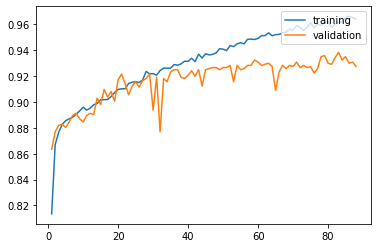

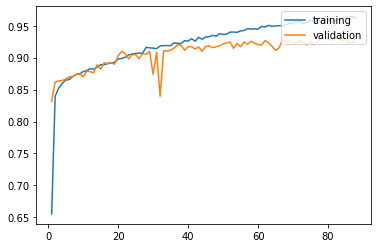

In [ ]:
plot_results(range(1,len(history.history['acc'])+1), 'acc', history)
plot_results(range(1,len(history.history['f1_score'])+1), 'f1_score', history)

**Model 3 - LSTM with custom attention layer with pre-trained embeddings**

In [25]:
class Attention(tf.keras.layers.Layer):    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=False),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)), 
          Attention(return_sequences = False),         
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "LSTM_customattention"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

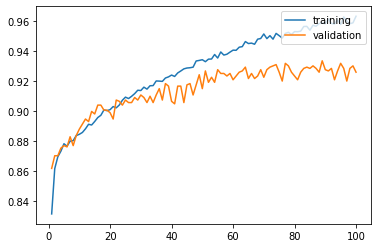

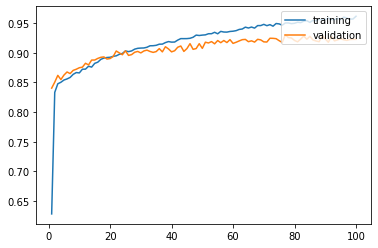

In [ ]:
plot_results(range(1,len(history.history['acc'])+1), 'acc', history)
plot_results(range(1,len(history.history['f1_score'])+1), 'f1_score', history)

**Model 4 - Bidrection LSTM with custom attention layer and embeddings as trainable layer**

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=True),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)), 
          Attention(return_sequences = False),         
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "LSTM_customattention"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

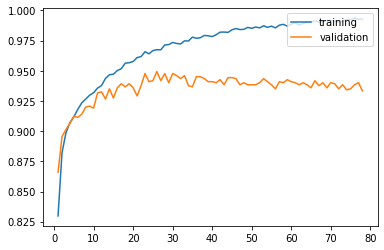

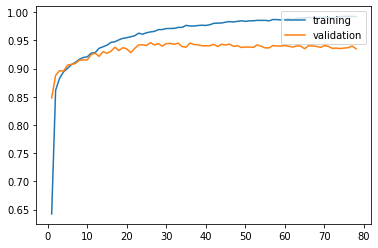

In [ ]:
plot_results(range(1,len(history.history['acc'])+1), 'acc', history)
plot_results(range(1,len(history.history['f1_score'])+1), 'f1_score', history)

**Model 4 - LSTM with keras attention layer**

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=False),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)), 
          SeqSelfAttention(attention_activation='softmax'), 
          tf.keras.layers.Flatten(),        
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "LSTM_attention"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

Epoch 1/100
334/334 [==============================] - ETA: 0s - loss: 0.5851 - acc: 0.8328 - f1_score: 0.6895
Epoch 00001: val_f1_score improved from -inf to 0.85417, saving model to LSTM_attention_best_model.h5
334/334 [==============================] - 31s 92ms/step - loss: 0.5851 - acc: 0.8328 - f1_score: 0.6895 - val_loss: 0.3902 - val_acc: 0.8735 - val_f1_score: 0.8542
Epoch 2/100
334/334 [==============================] - ETA: 0s - loss: 0.3773 - acc: 0.8655 - f1_score: 0.8399
Epoch 00002: val_f1_score improved from 0.85417 to 0.86178, saving model to LSTM_attention_best_model.h5
334/334 [==============================] - 31s 92ms/step - loss: 0.3773 - acc: 0.8655 - f1_score: 0.8399 - val_loss: 0.3437 - val_acc: 0.8761 - val_f1_score: 0.8618
Epoch 3/100
334/334 [==============================] - ETA: 0s - loss: 0.3504 - acc: 0.8739 - f1_score: 0.8509
Epoch 00003: val_f1_score did not improve from 0.86178
334/334 [==============================] - 30s 89ms/step - loss: 0.3504 - a

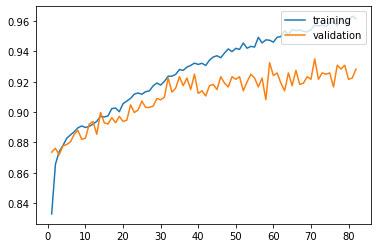

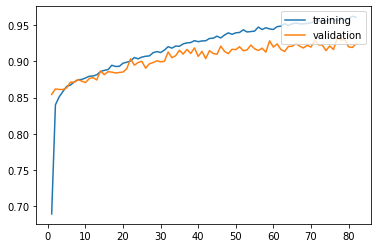

In [ ]:
plot_results(range(1,len(history.history['acc'])+1), 'acc', history)
plot_results(range(1,len(history.history['f1_score'])+1), 'f1_score', history)

**Model 5 - Bidirectional LSTM with keras attention layer and embedding layer to be trainable**

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=True),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)), 
          SeqSelfAttention(attention_activation='softmax'), 
          tf.keras.layers.Flatten(),        
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "LSTM_attention"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

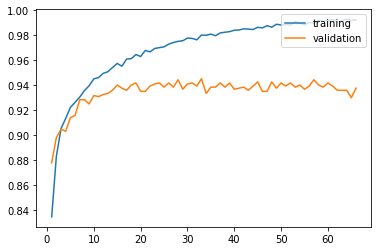

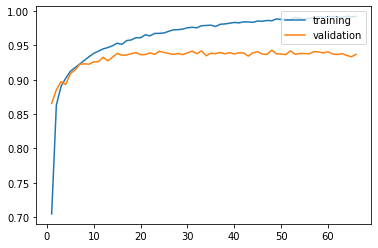

In [ ]:
plot_results(range(1,len(history.history['acc'])+1), 'acc', history)
plot_results(range(1,len(history.history['f1_score'])+1), 'f1_score', history)

**Model 5 - Embedding with CNN**

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], EMBEDDING_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=True),
          tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
          tf.keras.layers.MaxPooling1D(pool_size=2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')
          ])

name = "CNN"
model, history = train_model(model, epochs=100, lr=0.0001, name=name)

Epoch 1/100
333/334 [============================>.] - ETA: 0s - loss: 0.7559 - acc: 0.7816 - f1_score: 0.5757
Epoch 00001: val_f1_score improved from -inf to 0.78670, saving model to CNN_best_model.h5
334/334 [==============================] - 17s 51ms/step - loss: 0.7553 - acc: 0.7818 - f1_score: 0.5764 - val_loss: 0.4729 - val_acc: 0.8415 - val_f1_score: 0.7867
Epoch 2/100
333/334 [============================>.] - ETA: 0s - loss: 0.4203 - acc: 0.8565 - f1_score: 0.8153
Epoch 00002: val_f1_score improved from 0.78670 to 0.85003, saving model to CNN_best_model.h5
334/334 [==============================] - 17s 50ms/step - loss: 0.4201 - acc: 0.8565 - f1_score: 0.8154 - val_loss: 0.3952 - val_acc: 0.8752 - val_f1_score: 0.8500
Epoch 3/100
334/334 [==============================] - ETA: 0s - loss: 0.3551 - acc: 0.8786 - f1_score: 0.8520
Epoch 00003: val_f1_score improved from 0.85003 to 0.86400, saving model to CNN_best_model.h5
334/334 [==============================] - 17s 52ms/step -

### Step 4 - Test Prediction

In [27]:
#load test comments to run prediction
test_df  = pd.read_excel('./data/Test.xlsx')
test_df.head()

,id,comment
0,1,ouuuu 😍😍
1,2,i copped sidechick and hustle baby 2.0
2,3,i have mask acne and acne scars with a normal ...
3,4,i'm disappointed that your brand is promoting...
4,5,😢 what a waste of products😢 but genuine art ❤


In [28]:
test_processed_df = prepare_data(test_df, False)
test_processed_df[['id','comment','cleaned_comment']].head()

,id,comment,cleaned_comment
0,1,ouuuu 😍😍,"[wow, 😍, 😍]"
1,2,i copped sidechick and hustle baby 2.0,"[i, copped, sidekick, and, hustle, baby]"
2,3,i have mask acne and acne scars with a normal ...,"[i, have, mask, acne, and, acne, scars, with, ..."
3,4,i'm disappointed that your brand is promoting...,"[i, am, disappointed, that, your, brand, is, p..."
4,5,😢 what a waste of products😢 but genuine art ❤,"[😢, what, a, waste, of, products, 😢, but, genu..."


**Using either of the above trained models to run predictions**

In [1]:
#Loading the saved model to be used for predictions
best_model_name = "LSTM_best_model.h5"
reloaded_model = tf.keras.models.load_model(best_model_name, custom_objects={'f1_score':f1_score})
reloaded_model.summary()

In [ ]:
#convert test comments to sequences
test_transformed = cust_tokenizer.vectorize_input(test_processed_df['cleaned_comment'])
test_predictions = reloaded_model.predict(test_transformed)

In [ ]:
test_predictions

array([[5.9205637e-04, 9.9939358e-01, 8.6653063e-06, 5.6645040e-06],
       [7.3808628e-01, 2.6165086e-01, 1.7679966e-04, 8.6121487e-05],
       [2.2433376e-06, 9.9999774e-01, 4.9798768e-08, 7.9545753e-15],
       [1.8378487e-05, 1.0497617e-12, 9.9998152e-01, 6.5858934e-08],
       [7.4325253e-05, 1.3333145e-02, 6.2697702e-03, 9.8032272e-01]],
      dtype=float32)

In [ ]:
np.argmax(test_predictions, axis=1)

array([1, 0, 1, 2, 3])